In [1]:
%load_ext autoreload
%autoreload 2
%aimport -torch

In [11]:
import torch
try:  
    # Attempt to disable torch.compile for faster iteration, but if it fails 
    # (probably due to older pytorch version) we just proceed anyway
    torch.compiler.set_stance("force_eager")
except:
    pass

from omegaconf import OmegaConf
from flowmo import train_utils
import mediapy, einops

""

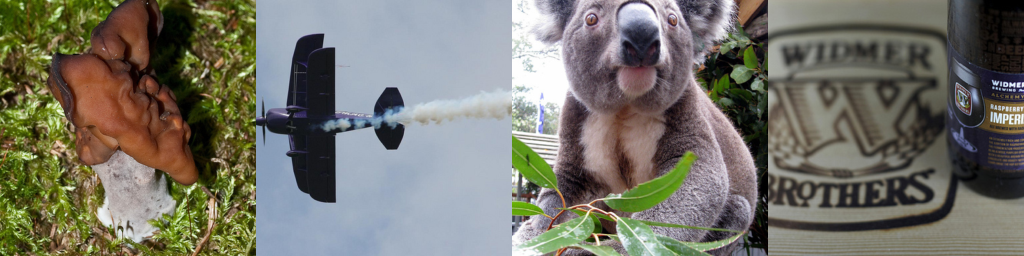

In [25]:
# Set up the data.
config = OmegaConf.load('flowmo/configs/base.yaml')
config.data.batch_size = 4
config.data.num_workers = 0

torch.manual_seed(1)
val_dataloader = train_utils.load_dataset(config, 'val', shuffle_val=True)
batch = next(train_utils.wrap_dataloader([next(iter(val_dataloader))]))

images = batch['image']
mediapy.show_image(einops.rearrange(images.cpu()/2+.5, "b c h w -> h (b w) c"), vmin=0, vmax=1)

In [ ]:
# Choose your model
model_name = "flowmo_hi"  

# The low BPP model has 18 bits per token, the high bitrate model has 56 bits per token.
zoo = {
    "flowmo_lo": {"context_dim": 18, "ckpt_path": "flowmo_lo.pth"},
    "flowmo_hi": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth"},
}

state_dict = torch.load(zoo[model_name]['ckpt_path'], map_location='cpu')
config.model.context_dim = zoo[model_name]['context_dim']
config.model.codebook_size_for_entropy = 1  # don't need this at test time.
model = train_utils.build_model(config)
model.load_state_dict(state_dict['model_ema_state_dict'])

Mup enabled!


<All keys matched successfully>

""

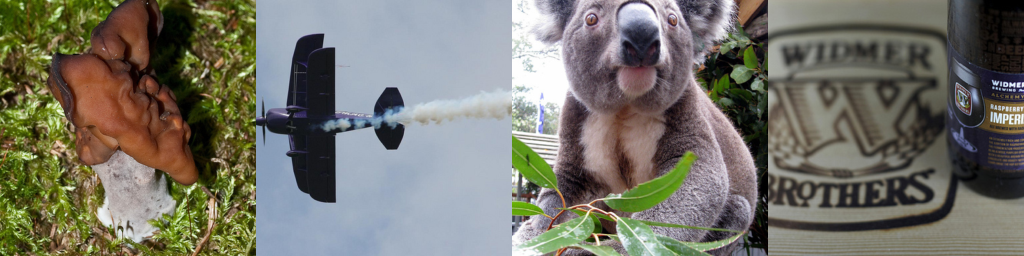

""

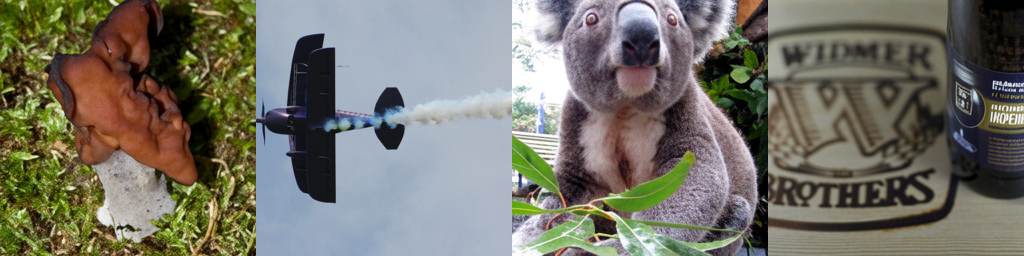

In [27]:
# Reconstruct the images. If you want to use your own images, FlowMo accepts
# images in [-1, 1] in bchw format.

model.eval()
with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
    images_rec = model.reconstruct(images)

# Show the original and reconstructed.
mediapy.show_image(einops.rearrange(images.cpu().numpy()/2+.5, "b c h w -> h (b w) c"))
mediapy.show_image(einops.rearrange(images_rec.cpu().numpy()/2+.5, "b c h w -> h (b w) c"))